In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import util
from scipy.linalg import orthogonal_procrustes
import json

data_path = "/home/projects/POPRES"
fname_all = f"{data_path}/POPRES_non-reduced_phased_allEur.npz"
fname_20 = f"{data_path}/POPRES_non-reduced_phased_allEur_20.npz"

local_data_path = "/home/jmhb/robust-dim-reduction-popgen/data"
fname_country_origins = f"{local_data_path}/country-origins.csv"
fname_colormap = f"{local_data_path}/country_colormap.json"
fname_languages = f"{local_data_path}/dslanguages.csv"
fname_languages_lookup = f"{local_data_path}/languages_lookup.json"

### Choose dataset, get data and labels

In [293]:
dataset='20'        # 'all' or '20'
def get_data(dataset='20'):
    if dataset=='all': fname=fname_all
    elif dataset=='20': fname=fname_20
    else: raise ValueError("Datset in ('all','20')")

    # Get data and labels
    data_npz = np.load(fname, allow_pickle=True)
    df = pd.DataFrame(data_npz['gt_matrix'], index=data_npz['ind_IDs'])
    df_labels = pd.DataFrame(data_npz['labels'], index=data_npz['ind_IDs'])
    df_labels.columns = ['country']

    assert len(df)==len(df_labels)

    df_country = pd.read_csv(fname_country_origins)
    df_country = df_country.rename(columns={"Geographic-Origin":"country"})

    ### some modifications 
    # fix the missing dashes
    df_labels['country']=df_labels['country'].str.replace(' ','-')
    # combine the swiss data
    swiss_mask = df_labels['country'].isin(['Swiss-French','Swiss-German','Swiss-Italian','Switzerland']).values
    df_labels['country'] = df_labels['country'].where(~swiss_mask, other='Switzerland')
    # drop the Slovakian samples
    drop_slovakia = df_labels[df_labels['country'].isin(['Slovakia'])].index
    df.drop(drop_slovakia, inplace=True)
    df_labels.drop(drop_slovakia, inplace=True)
    # Set the Switzerland abbreviation
    swiss_idx = df_country[df_country['country']=='Switzerland'].index
    df_country.loc[swiss_idx, 'Abbreviation'] = 'CH'
    scotland_idx = df_country[df_country['country']=='Scotland'].index
    df_country.loc[scotland_idx, 'Abbreviation'] = 'SC'

    ### load colormap for plotting 
    color_map = json.load(open(fname_colormap))

    ### load language data
    df_dist_language = pd.read_csv(fname_languages)
    df_dist_language = df_dist_language.set_index('Unnamed: 0')
    df_dist_language.index.name='language'
    languages_lookup = json.load(open(fname_languages_lookup))
    languages_lookup.pop("Albania")
    # filter out countries with no language data 
    df_labels['language'] = df_labels['country'].map(languages_lookup)
    keep_indx_language = df_labels[df_labels['language']==df_labels['language']].index
    df_language = df.loc[keep_indx_language]
    df_labels_language = df_labels.loc[keep_indx_language]
    # build the language-based distance matrix between samples
    label_languages = df_labels_language['language']
    df_dist_sample_languages = df_dist_language.loc[label_languages, label_languages]
    df_dist_sample_languages.index, df_dist_sample_languages.columns = df_language.index, df_language.index
    
    return df, df_labels, df_language, df_dist_sample_languages, df_country, keep_indx_language, df_labels_language, df_dist_sample_languages

In [354]:
dataset = 'all'
df, df_labels, df_language, df_dist_sample_languages, df_country, keep_indx_language, df_labels_language, df_dist_sample_languages = get_data(dataset)

In [296]:
# df_dist = util.build_distance_matrix(df)


## 1 Run all the models

In [280]:
dataset = '20'
df, df_labels, df_language, df_dist_sample_languages, df_country, keep_indx_language, df_labels_language, df_dist_sample_languages = get_data(dataset)
print("regular pca")
# ## Regular PCA
M = util.build_matrix(util.clean(df))
res_pca_20 = util.do_pca(M)

# ## Normalized PCA
# df_dist = util.build_distance_matrix(df)
print("1")
res_norm_20_1 = util.do_normalized_pca(df, df_dist, dist_func=lambda x: 1/x)
print("2")
res_norm_20_2 = util.do_normalized_pca(df, df_dist, dist_func=lambda x: 1/x**2)
print("3")
res_norm_20_3 = util.do_normalized_pca(df, df_dist, dist_func=lambda x: 1/x**3)

## language only 
print("language")
res_language_20 = util.do_normalized_pca(df_language, df_dist_sample_languages, dist_func=lambda x: np.log(x+1))

# language-supervised pca. This removes some data due to no language distance data
print("robust & language")
res_lang_and_gen_20_1 = do_robust_and_language(df_language, df_dist, df_dist_sample_languages
                                            , dist_func_gen = lambda x: 1/x**2
                                            , dist_func_lang = lambda x: np.log(x+1))

In [281]:
import pickle
all_results_20 = {
    "res_pca_20":res_pca_20,
    "res_norm_20_1":res_norm_20_1,
    "res_norm_20_2":res_norm_20_2,
    "res_norm_20_3":res_norm_20_3,
    "res_language_20":res_language_20,
    "res_lang_and_gen_20_1":res_lang_and_gen_20_1,
}

# all_results_all = {
#     "res_pca_all":res_pca_all,
#     "res_norm_all_1":res_norm_all_1,
#     "res_norm_all_2":res_norm_all_2,
#     "res_norm_all_3":res_norm_all_3,
#     "res_language_all":res_language_all,
#     "res_lang_and_gen_all_1":res_lang_and_gen_all_1,
# }
with open('all_results_20.pickle', 'wb') as handle:
    pickle.dump(all_results_20, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('all_results_all.pickle', 'wb') as handle:
#     pickle.dump(all_results_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [235]:
with open('all_results_20.pickle', 'rb') as handle:
    all_results_20= pickle.load(handle)

In [69]:
"""
dataset = 'all'
df, df_labels, df_language, df_dist_sample_languages, df_country = get_data(dataset)

## Regular PCA
M = util.build_matrix(util.clean(df))
res_pca_all = util.do_pca(M)

## Normalized PCA
df_dist_all = util.build_distance_matrix(df)
"""
print("starting")
res_norm_all_1 = util.do_normalized_pca(df, df_dist, dist_func=lambda x: 1/x)
res_norm_all_2 = util.do_normalized_pca(df, df_dist, dist_func=lambda x: 1/x**2)
res_norm_all_3 = util.do_normalized_pca(df, df_dist, dist_func=lambda x: 1/x**3)

## language only 
res_language_all = util.do_normalized_pca(df_language, df_dist_sample_languages, dist_func=lambda x: np.log(x+1))

## language-supervised pca. This removes some data due to no language distance data
res_lang_and_gen_all_1 = do_robust_and_language(df_language, df_dist, df_dist_sample_languages
                                            , dist_func_gen = lambda x: 1/x**2
                                            , dist_func_lang = lambda x: np.log(x+1))

starting


### Plotting methods

In [21]:
def rotate(theta):
    theta= theta*np.pi/180 
    return np.array([[np.cos(theta), -np.sin(theta)],
                         [np.sin(theta), np.cos(theta)]])
def reflect_x():
    return np.array([[1,0],
                     [0,-1]])

def reflect_y():
    return np.array([[-1,0],
                     [0,1]])

def compose_transform(*args):
    """ Each argument is a square matrix with equal dimension. """
    transform = args[0]
    for arg in args[1:]:
        transform = transform.dot(arg)
    return transform

def do_transform(A, transform):
    """ 
    Apply euclidean transformation to a sequence of points `dim`-dimensional space
    A.shape==(n_points, dims),
    transform.shape==(dims,dims)    
    """
    return transform.dot(A.T).T 


In [277]:
from statsmodels.stats.correlation_tools import cov_nearest
def build_combinde_laplacian(df_dist_gen, dist_func_gen, df_dist_geo, dist_func_geo):
    print('a')
    L_weight_gen = dist_func_gen(df_dist_gen)
    np.fill_diagonal(L_weight_gen.values, 0)
    
    L_weight_geo = dist_func_geo(df_dist_geo)
    np.fill_diagonal(L_weight_geo.values, 0)
    
    # elementwise multiply
    L_weigh_comb = np.multiply(L_weight_gen, L_weight_geo)

    # Turn into a standard Laplacian 
    np.fill_diagonal(L_weigh_comb.values, -L_weigh_comb.sum())
    L_weigh_comb = -L_weigh_comb
    L_weigh_comb = cov_nearest(L_weigh_comb)
    L = np.linalg.cholesky(L_weigh_comb)
    
    return L, L_weight_gen, L_weight_geo
 
def do_robust_and_language(df_language, df_dist, df_dist_sample_languages, dist_func_gen, dist_func_lang):
    L, L_weight_gen, L_weight_lang = build_combinde_laplacian(df_dist.loc[keep_indx_language,keep_indx_language]
    , dist_func_gen, df_dist_sample_languages, dist_func_lang)
    M=util.build_matrix(util.clean(df_language))
    A=L.dot(M)
    res_lang_and_gen_log = util.do_pca(A, n_components=10)
    return res_lang_and_gen_log

dist_func_gen = lambda x: 1/x**2
dist_func_lang = lambda x: np.log(x+1)
# res_lang_and_gen_log = do_robust_and_language(df_language, df_dist, df_dist_sample_languages, dist_func_gen,dist_func_lang)


In [150]:
def do_plot(df_plot, df_plot_means, plot_pcs=True, plot_all=True, figsize=(20,20)
            , theta=60, equal_aspect=True, label_pcs=True):
    A = df_plot_means[['pc1','pc2']]
    B = df_plot[['pc1','pc2']]
    pc1_range = [A['pc1'].min(), A['pc1'].max()]
    pc2_range = [A['pc2'].min(), A['pc2'].max()]
    pc1_axis = np.array([[pc1_range[0], 0], [pc1_range[1], 0]])
    pc2_axis = np.array([[0, pc2_range[0]], [0, pc2_range[1]]])

    transform = compose_transform(reflect_x(), rotate(theta))
    A_rot = do_transform(A, transform)
    B_rot = do_transform(B, transform)

    df_plot_means['pc_rot_x']= A_rot[:,0]
    df_plot_means['pc_rot_y']= A_rot[:,1]
    df_plot['pc_rot_x'] = B_rot[:,0]
    df_plot['pc_rot_y'] = B_rot[:,1]

    pc1_axis_rot = do_transform(pc1_axis, transform)
    pc2_axis_rot = do_transform(pc2_axis, transform)

    #### Plots
    ## marker sizes
    pcs_lw=2
    marker_s=10
    arrow_size=30

    ## Use means to control the bounds 
    xlim = [df_plot_means['pc_rot_x'].min(), df_plot_means['pc_rot_x'].max()]
    ylim = [df_plot_means['pc_rot_y'].min(), df_plot_means['pc_rot_y'].max()]
    f, axs = plt.subplots(1,1, figsize=figsize)

    ## Plot everything
    if plot_all:
        for i, row in df_plot.iterrows():
            x, y = row[['pc_rot_x', 'pc_rot_y']]
            marker = row['Abbreviation']
            color = row['color']
            axs.text(x,y,marker, color=color, clip_on=True, weight='bold', fontsize=5)

    ## Country means
    for i, row in df_plot_means.iterrows():
        x, y = row[['pc_rot_x', 'pc_rot_y']]
        marker = row['Abbreviation']
        color = row['color']
        axs.text(x,y,marker, color='k', size=marker_s
                 , bbox=dict(boxstyle="circle",facecolor=color, linewidth=0), )

    if plot_pcs:
        axs.annotate(s='', xy=pc1_axis_rot[0,:], xytext=pc1_axis_rot[1,:]
                     , arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
        axs.annotate(s='', xy=pc2_axis_rot[0,:], xytext=pc2_axis_rot[1,:]
                     , arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    shift_pc1 = [0.00,-0.00]
    shift_pc2 = [0.00,-0.00]
    if label_pcs:
        axs.text(*pc1_axis_rot[0,:]+shift_pc1, s="PC1", rotation=-theta)
        axs.text(*pc2_axis_rot[0,:]+shift_pc2, s="PC2", rotation=-theta+90)

    axs.set(xlim=xlim, ylim=ylim, clip_on=True)
    if equal_aspect:
        plt.gca().set_aspect('equal', adjustable='box')
    axs.set_axis_off()
    return f, axs

def adjust_plot_means_marker(df_plot_means, adjustments):
    """inplace"""
    pc1_range = df_plot_means['pc1'].max()-df_plot_means['pc1'].min()
    pc2_range = df_plot_means['pc1'].max()-df_plot_means['pc2'].min()
    
    # adjust the pcs
    for adj in adjustments:
        idx = df_plot_means[df_plot_means['Abbreviation']==adj[0]].index[0]
        df_plot_means.loc[idx, 'pc1'] += pc1_range*adj[1][0]
        df_plot_means.loc[idx, 'pc2'] += pc1_range*adj[1][1]
    return df_plot_means



In [20]:
def get_plotting_data(res, df_labels):
    color_method = 2
    # start building dataframe to hold the PC projection data
    df_plot = pd.DataFrame(res['PC_projection'][:,:2]
                           , index=df_labels.index
                           , columns=['pc1','pc2'])

    # choose plotting colors per country 
    N_countries = len(df_country)
    # hsv = plt.get_cmap('hsv')
    if color_method==0:
        df_country['color'] = [hsv(v) for v in np.linspace(0,1,N_countries)]
    elif color_method==1:
        df_country['color'] = sns.color_palette("husl", N_countries)
    elif color_method==2:
        df_country['color'] = df_country['country'].map(color_map)
    else:
        raise ValueError()

    # join on the country label and country data 
    df_plot = df_plot\
        .join(df_labels)\
        .merge(df_country)
    df_plot.index=df_labels.index

    ## compute centroids
    # merge the swiss countries together
    df_plot_means = df_plot.groupby('country')[['pc1','pc2']].mean()
    df_plot_means = df_plot_means.reset_index().merge(df_country)
    
    return df_plot, df_plot_means

## Do the 'all' plots

(4814, 10)


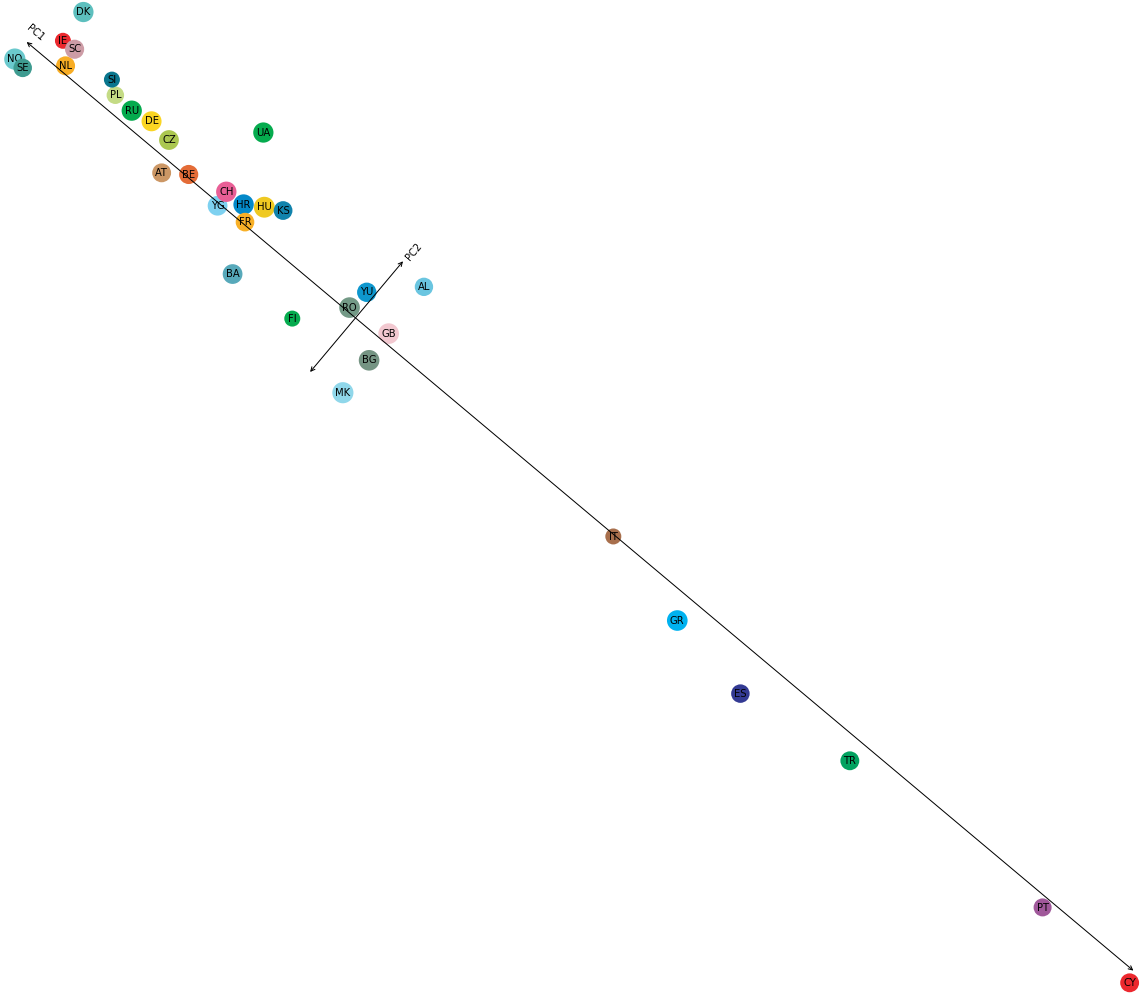

In [355]:
# pca no markers
df_plot, df_plot_means = get_plotting_data(res_pca_all, df_labels)
print(res_pca_all['PC_projection'].shape)
df_plot_means = adjust_plot_means_marker(df_plot_means, 
                                         [ ('DE',[-0.01,0]),
                                           ('FR',[0,0.01]),
                                           ('SC',[-0.00,-0.01]),
                                           ('YU',[-0.00,-0.01]),
                                         ])
f, axs = do_plot(df_plot, df_plot_means, plot_all=False, figsize=(20,20), theta=40)
f.savefig("./results/imgs/pca-all-means.svg")

(4814, 10)


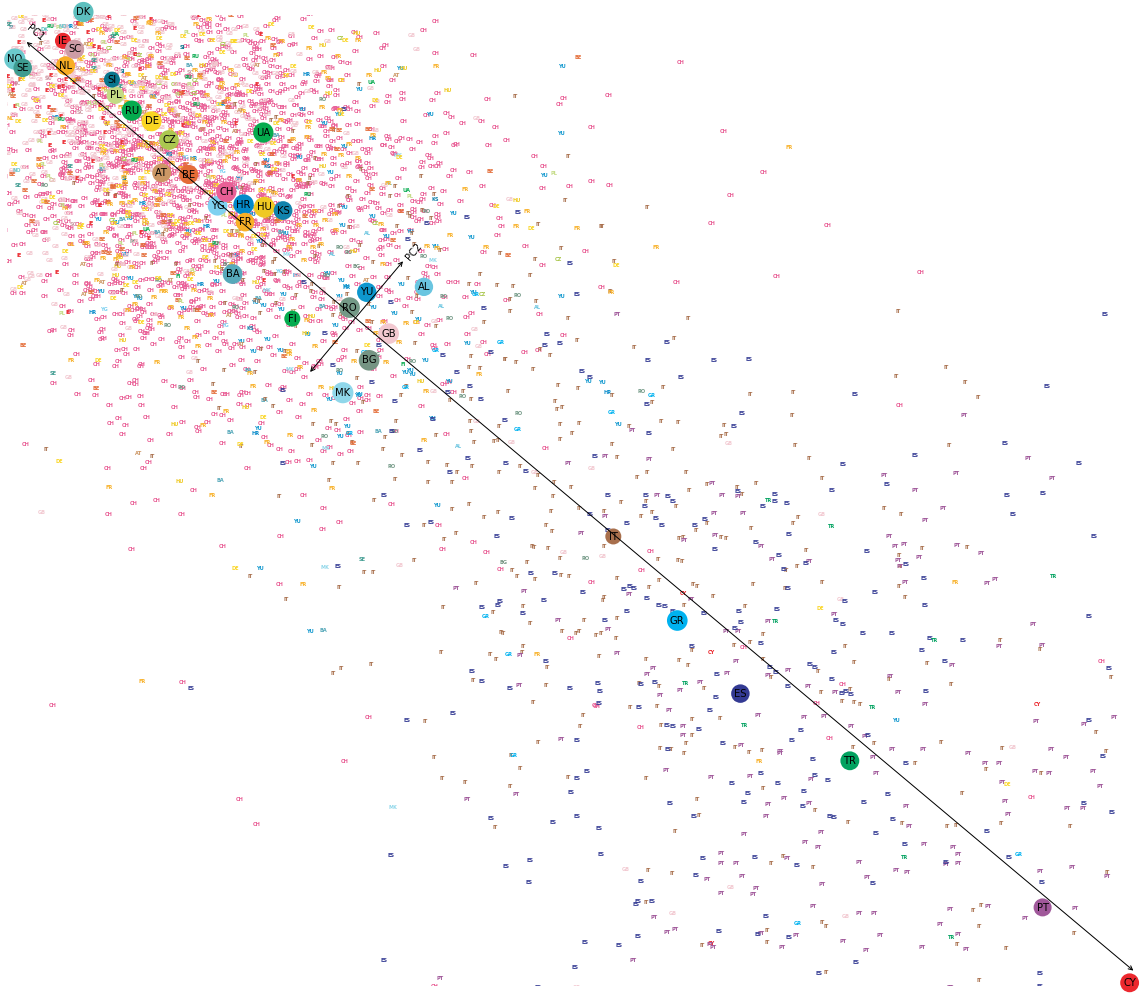

In [356]:
# regular pca markers+samples
df_plot, df_plot_means = get_plotting_data(res_pca_all, df_labels)
print(res_pca_all['PC_projection'].shape)
df_plot_means = adjust_plot_means_marker(df_plot_means, 
                                         [ ('DE',[-0.01,0]),
                                           ('FR',[0,0.01]),
                                           ('SC',[-0.00,-0.01]),
                                           ('YU',[-0.00,-0.01]),
                                         ])
f, axs = do_plot(df_plot, df_plot_means, plot_all=True, figsize=(20,20), theta=40)
f.savefig("./results/imgs/pca-all-means_and_samples.svg")

(4814, 10)


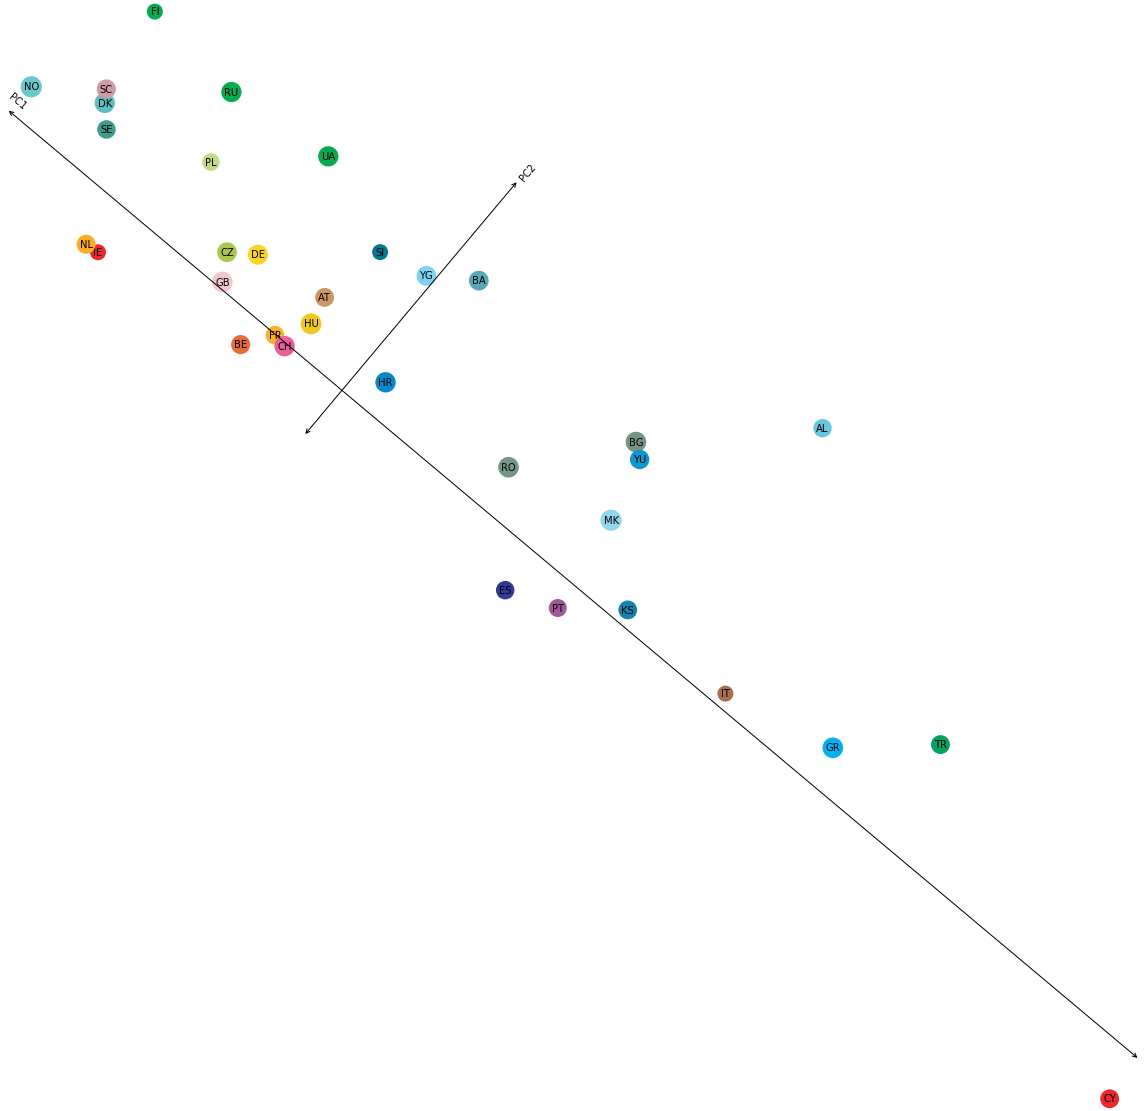

In [342]:
# normalized pca pca markers only
df_plot, df_plot_means = get_plotting_data(res_norm_all_2, df_labels)
print(res_norm_all_2['PC_projection'].shape)
df_plot_means = adjust_plot_means_marker(df_plot_means, 
                                         [
#                                           ('NL',[0.03,0.00]),
                                          ('CH',[0.005,0.005]),
                                          ('SC',[-0.0075,-0.0075]),
                                         ])
f, axs = do_plot(df_plot, df_plot_means, plot_all=False, figsize=(20,20), theta=40)
f.savefig("./results/imgs/norm_pca-all-means.svg")

(4814, 10)


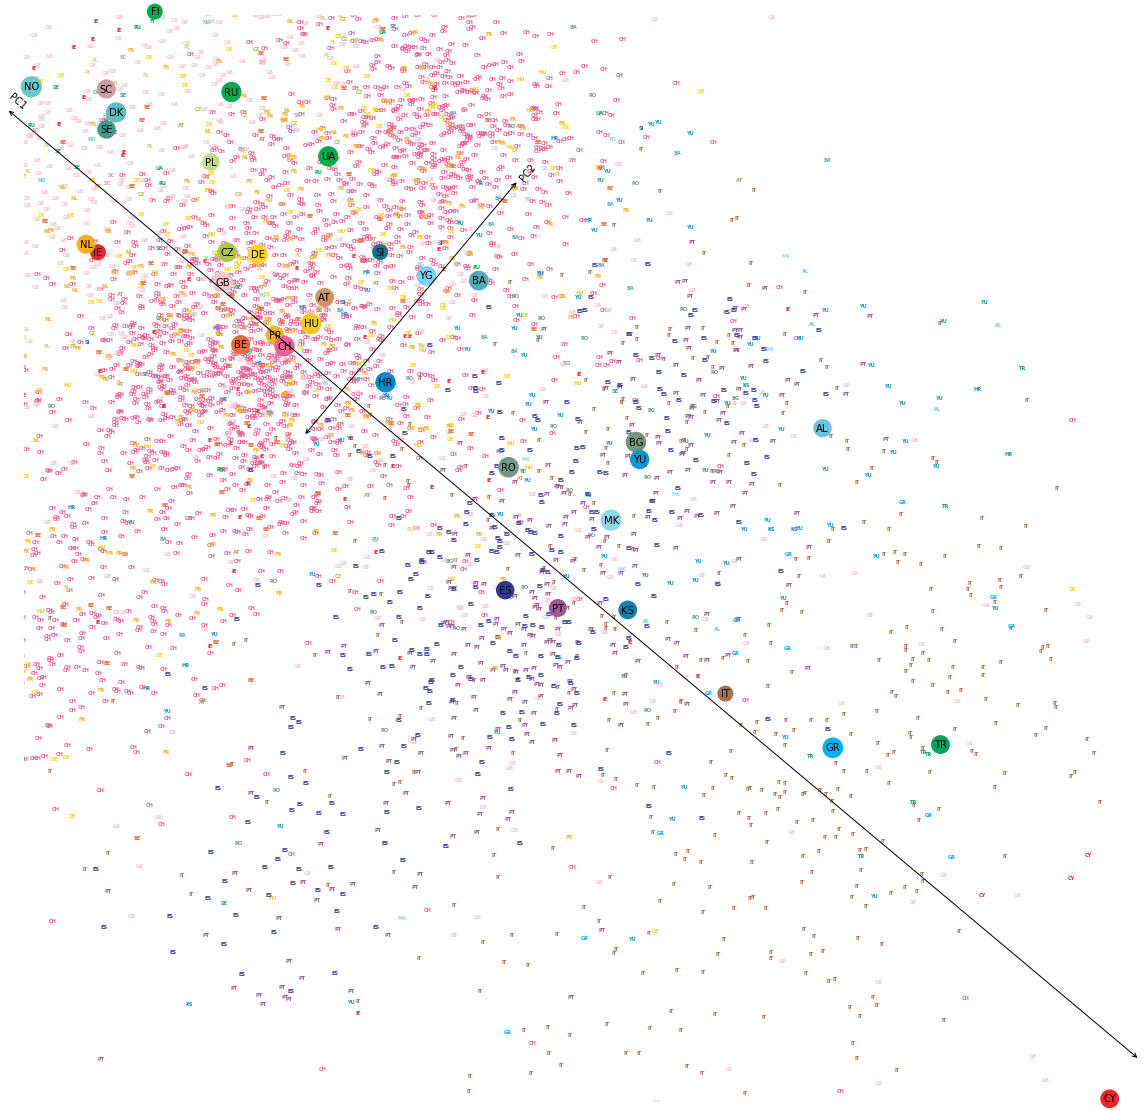

In [343]:
# normalized pca pca markers+samples
df_plot, df_plot_means = get_plotting_data(res_norm_all_2, df_labels)
print(res_norm_all_2['PC_projection'].shape)
df_plot_means = adjust_plot_means_marker(df_plot_means, 
                                         [
#                                           ('NL',[0.03,0.00]),
                                          ('CH',[0.005,0.005]),
                                          ('SC',[-0.0075,-0.0075]),
                                         ])
df_plot_means = adjust_plot_means_marker(df_plot_means, [ ('DK',[0.01,0]),])
f, axs = do_plot(df_plot, df_plot_means, plot_all=True, figsize=(20,20), theta=40)
f.savefig("./results/imgs/norm_pca-all-means_and_samples.svg")

(4756, 10)


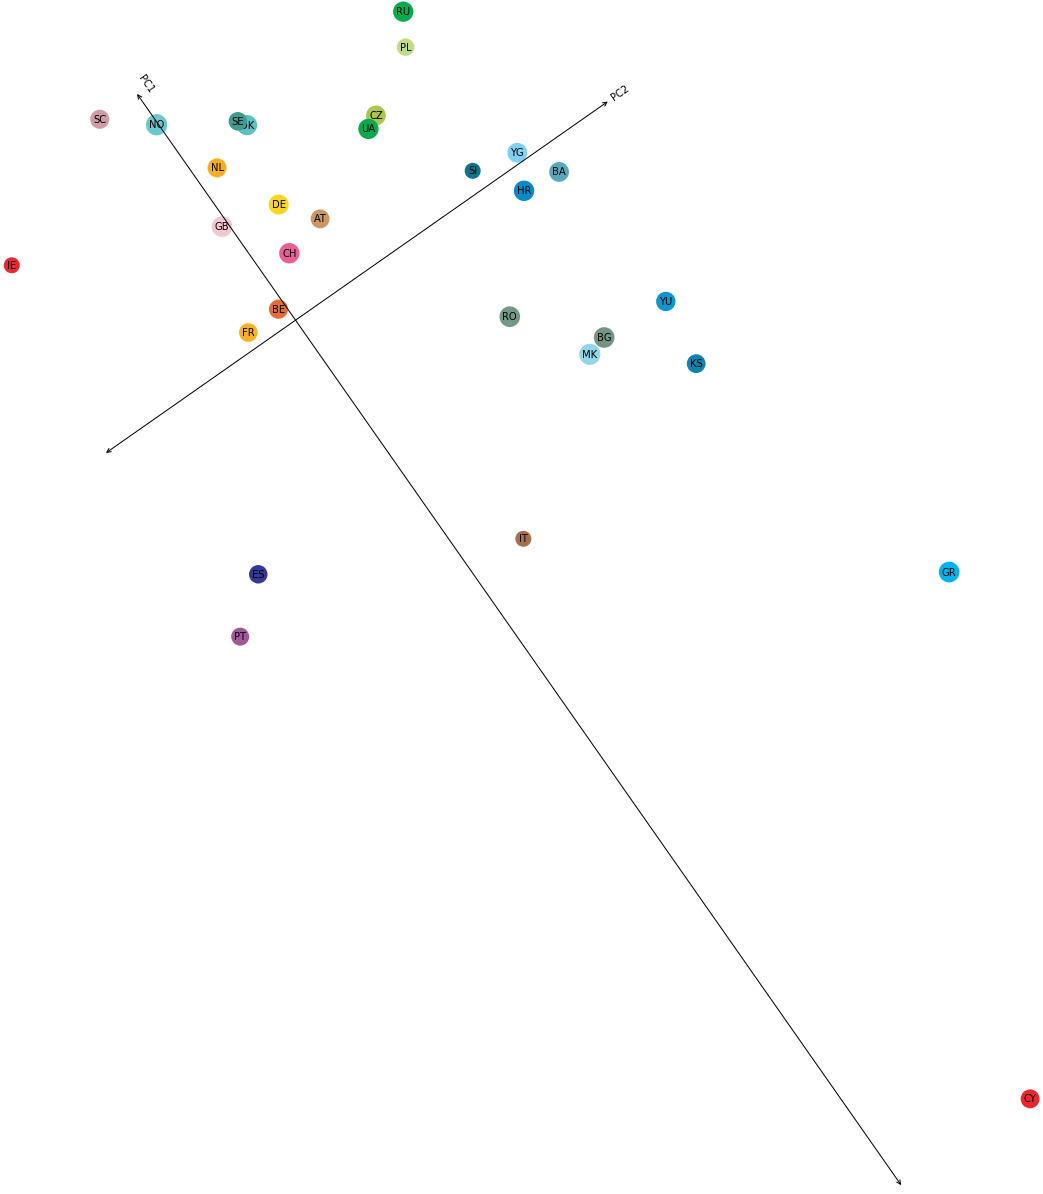

In [344]:
# robust + language
df_plot, df_plot_means = get_plotting_data(res_lang_and_gen_all_1, df_labels_language)
print(res_lang_and_gen_all_1['PC_projection'].shape)
df_plot_means = adjust_plot_means_marker(df_plot_means, [ 
                                            ('DK',[0.01,0]),
                                                    ])
f, axs = do_plot(df_plot, df_plot_means, plot_all=False, figsize=(20,20), theta=55)
f.savefig("./results/imgs/pca_norm_and_lang-all-means.svg")

(4756, 10)


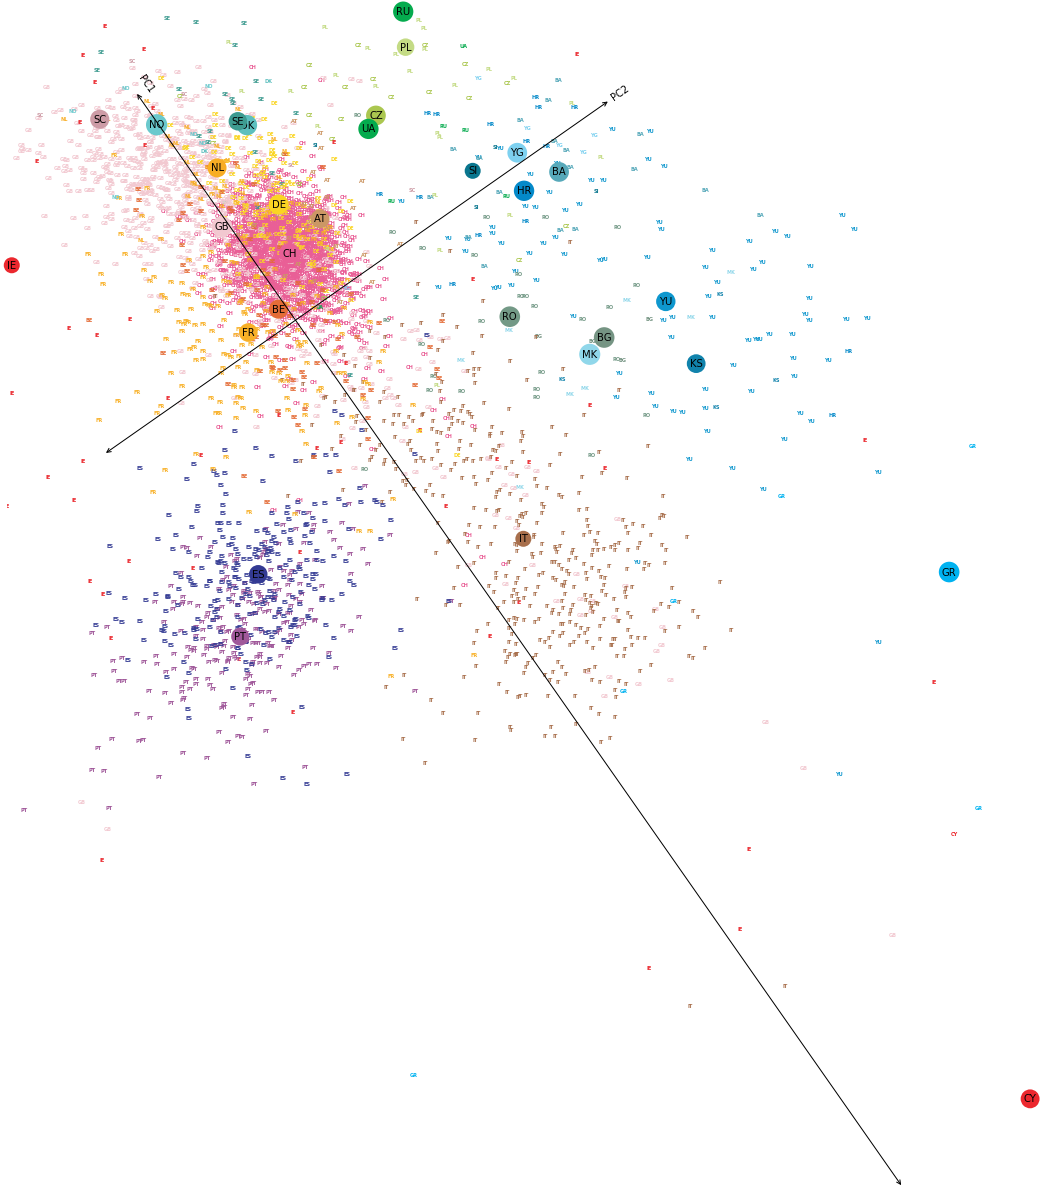

In [345]:
# robust + language
df_plot, df_plot_means = get_plotting_data(res_lang_and_gen_all_1, df_labels_language)
print(res_lang_and_gen_all_1['PC_projection'].shape)
df_plot_means = adjust_plot_means_marker(df_plot_means, [ 
                                            ('DK',[0.01,0]),
                                                    ])
f, axs = do_plot(df_plot, df_plot_means, plot_all=True, figsize=(20,20), theta=55)
f.savefig("./results/imgs/pca_norm_and_lang-all-means_and_samples.svg")

## Do the '20' plots

856


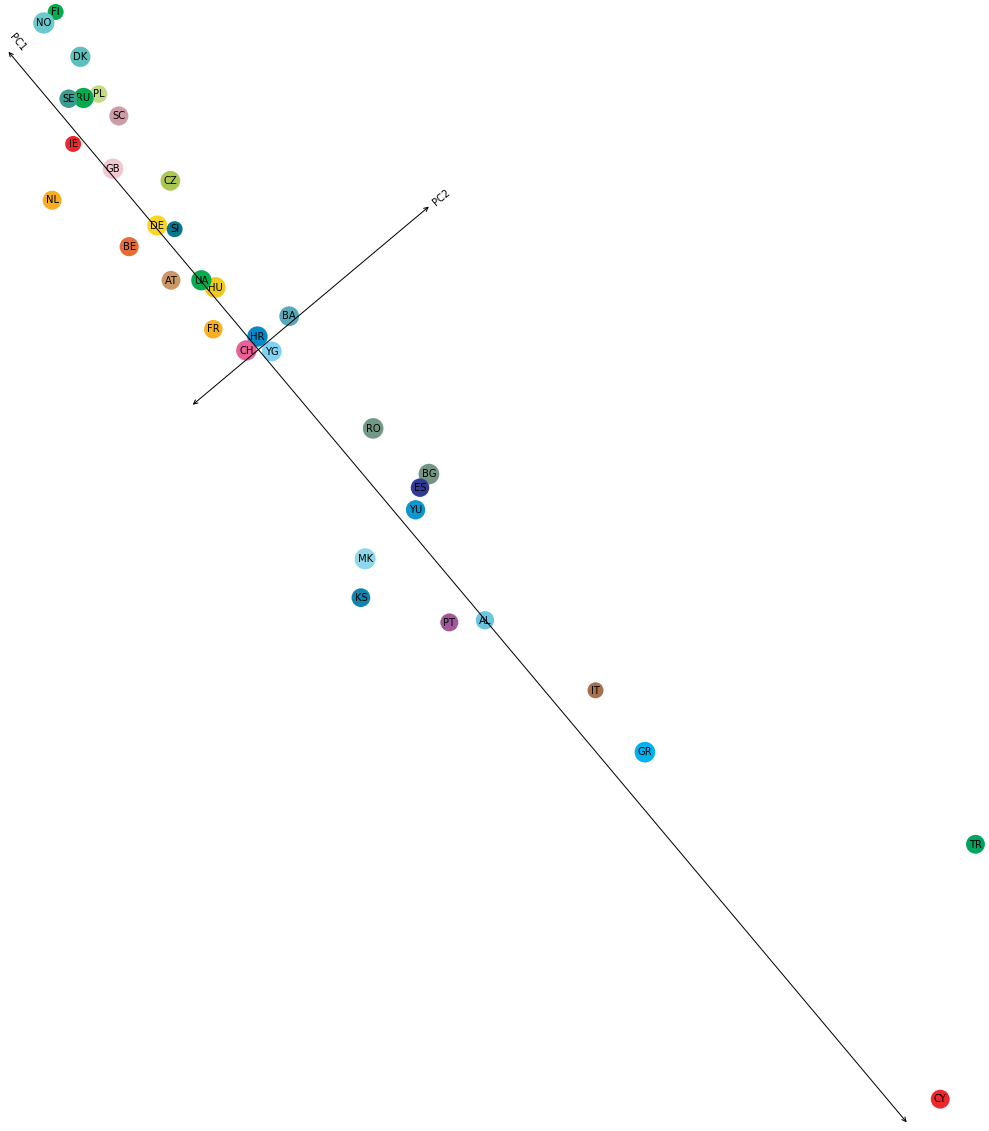

In [347]:
# pca no markers
print(len(res_pca_20['PC_projection']))
df_plot, df_plot_means = get_plotting_data(res_pca_20, df_labels)
df_plot_means = adjust_plot_means_marker(df_plot_means, 
                                         [ ('YG',[0.01,0]),
                                           ('NO',[0,0.02]),
                                           ('BG',[-0.00,-0.005]),
                                         ])
f, axs = do_plot(df_plot, df_plot_means, plot_all=False, figsize=(20,20), theta=50)
f.savefig("./results/imgs/pca-20-means.svg")

856


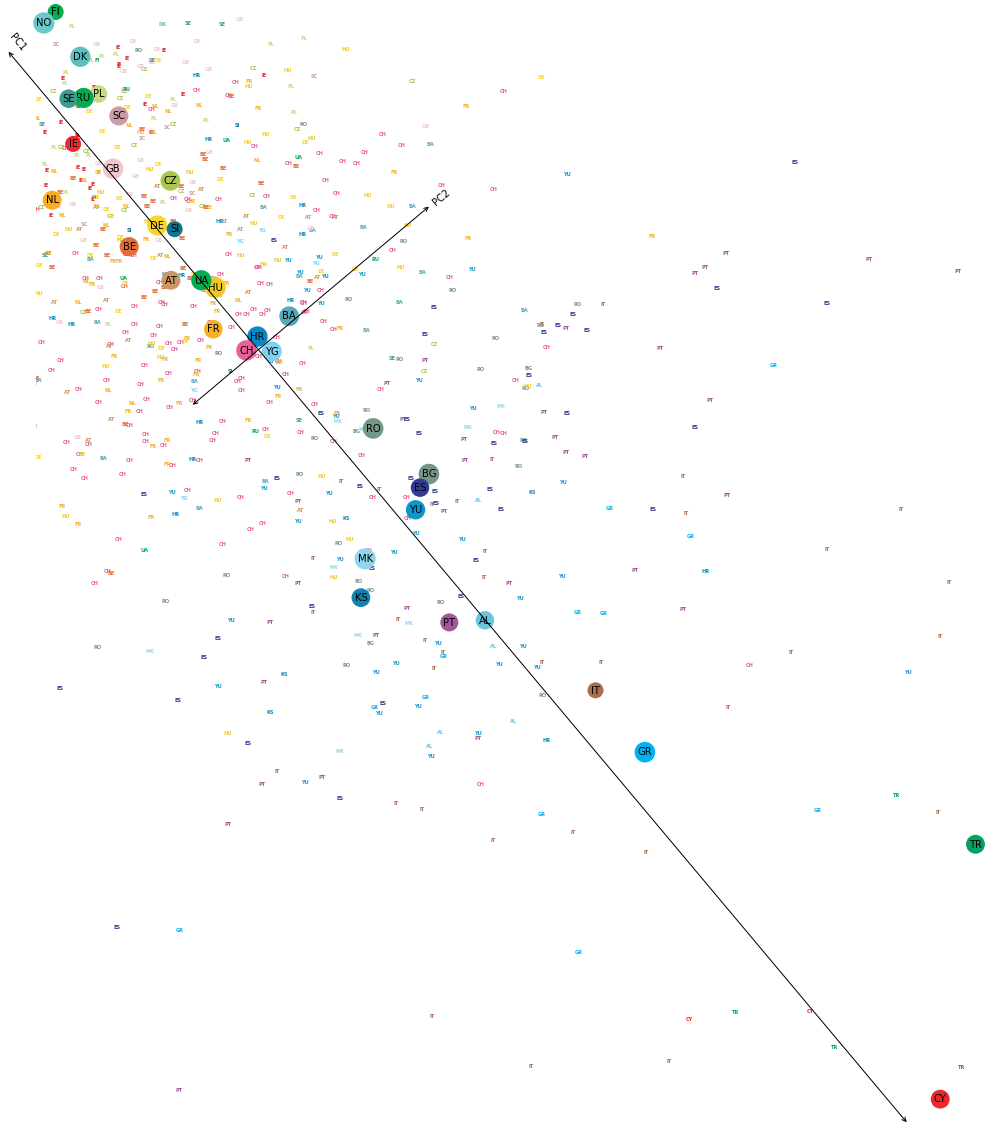

In [353]:
# pca no markers+samples
print(len(res_pca_20['PC_projection']))
df_plot, df_plot_means = get_plotting_data(res_pca_20, df_labels)
df_plot_means = adjust_plot_means_marker(df_plot_means, 
                                         [ ('YG',[0.01,0]),
                                           ('NO',[0,0.02]),
                                           ('BG',[-0.00,-0.005]),
                                         ])
f, axs = do_plot(df_plot, df_plot_means, plot_all=True, figsize=(20,20), theta=50)
f.savefig("./results/imgs/pca-20-means_and_samples.svg")

(856, 10)


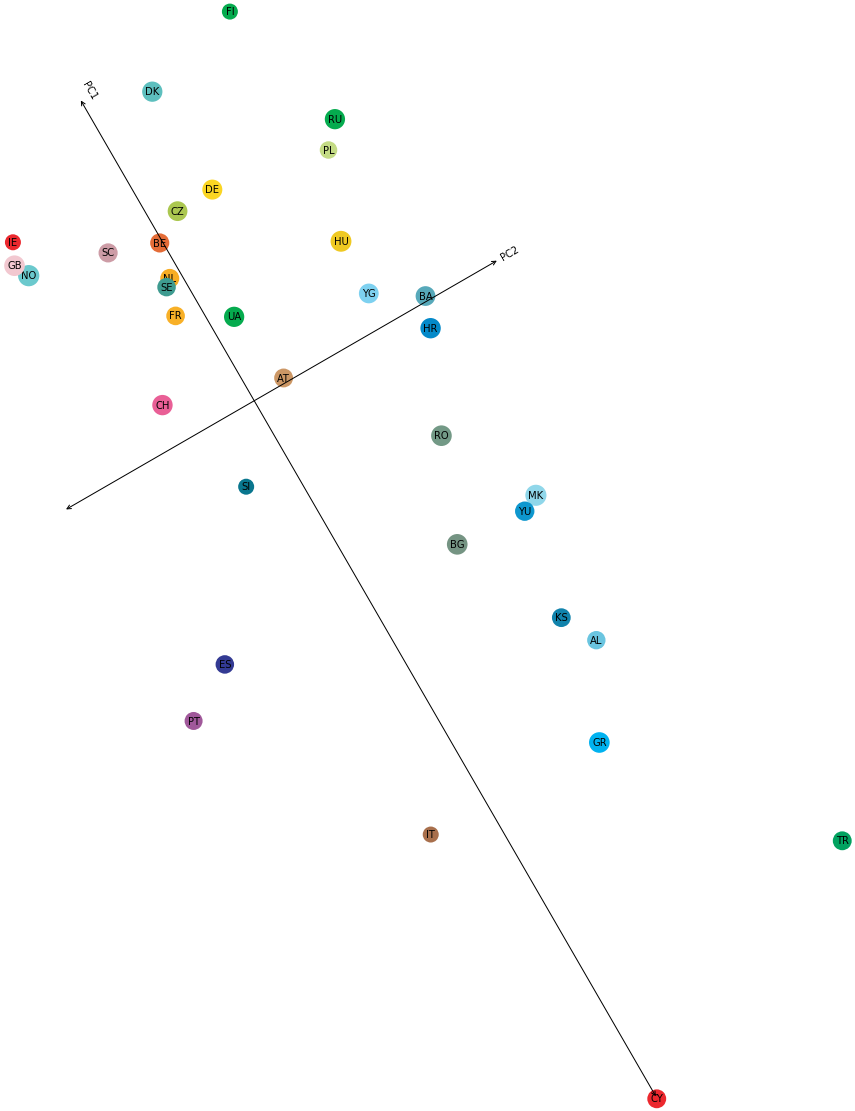

In [349]:
# normalized pca pca markers only
df_plot, df_plot_means = get_plotting_data(res_norm_20_2, df_labels)
print(res_norm_20_2['PC_projection'].shape)
df_plot_means = adjust_plot_means_marker(df_plot_means, 
                                         [
#                                           ('NL',[0.03,0.00]),
                                          ('CH',[0.005,0.005]),
                                          ('SC',[-0.0075,-0.0075]),
                                         ])
f, axs = do_plot(df_plot, df_plot_means, plot_all=False, figsize=(20,20), theta=60)
f.savefig("./results/imgs/norm_pca-all-means.svg")

(856, 10)


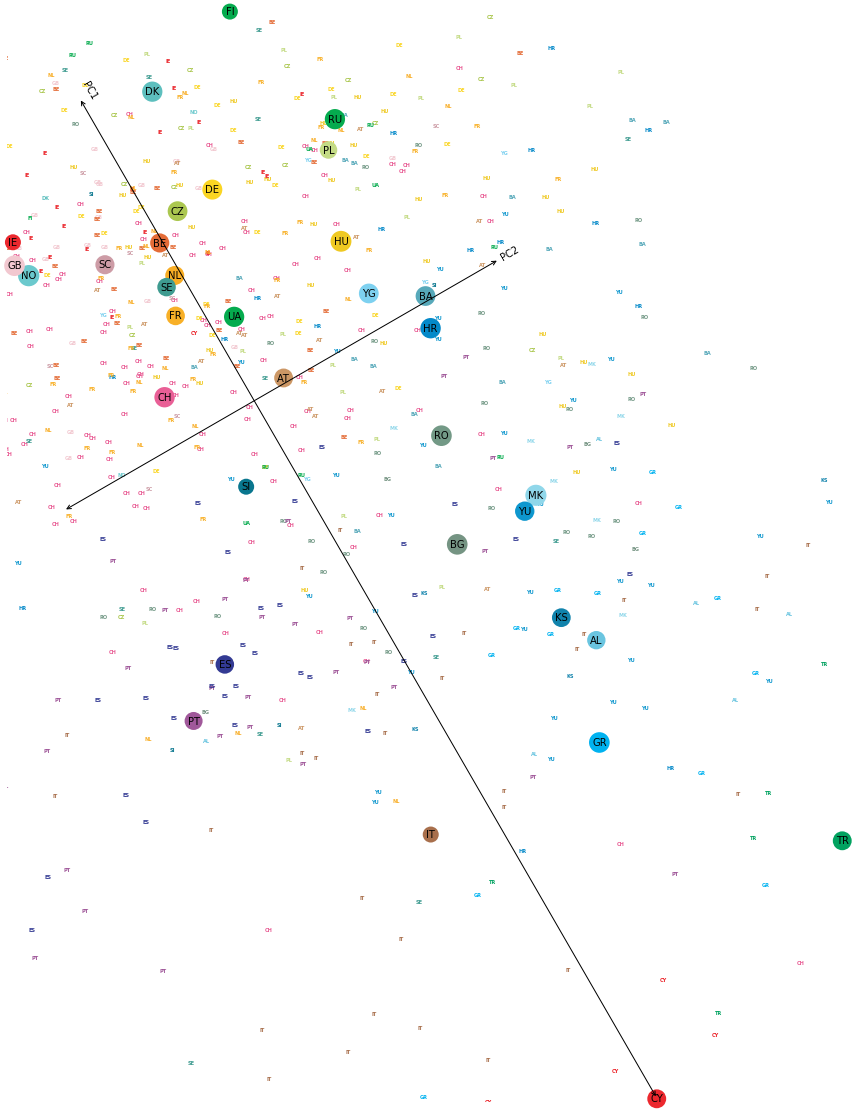

In [350]:
# normalized pca pca markers + samples
df_plot, df_plot_means = get_plotting_data(res_norm_20_2, df_labels)
print(res_norm_20_2['PC_projection'].shape)
df_plot_means = adjust_plot_means_marker(df_plot_means, 
                                         [
                                          ('NL',[0.0,-0.005]),
#                                           ('CH',[0.005,0.005]),
#                                           ('SC',[-0.0075,-0.0075]),
                                         ])
f, axs = do_plot(df_plot, df_plot_means, plot_all=True, figsize=(20,20), theta=60)
f.savefig("./results/imgs/norm_pca-all-means.svg")


(798, 10)


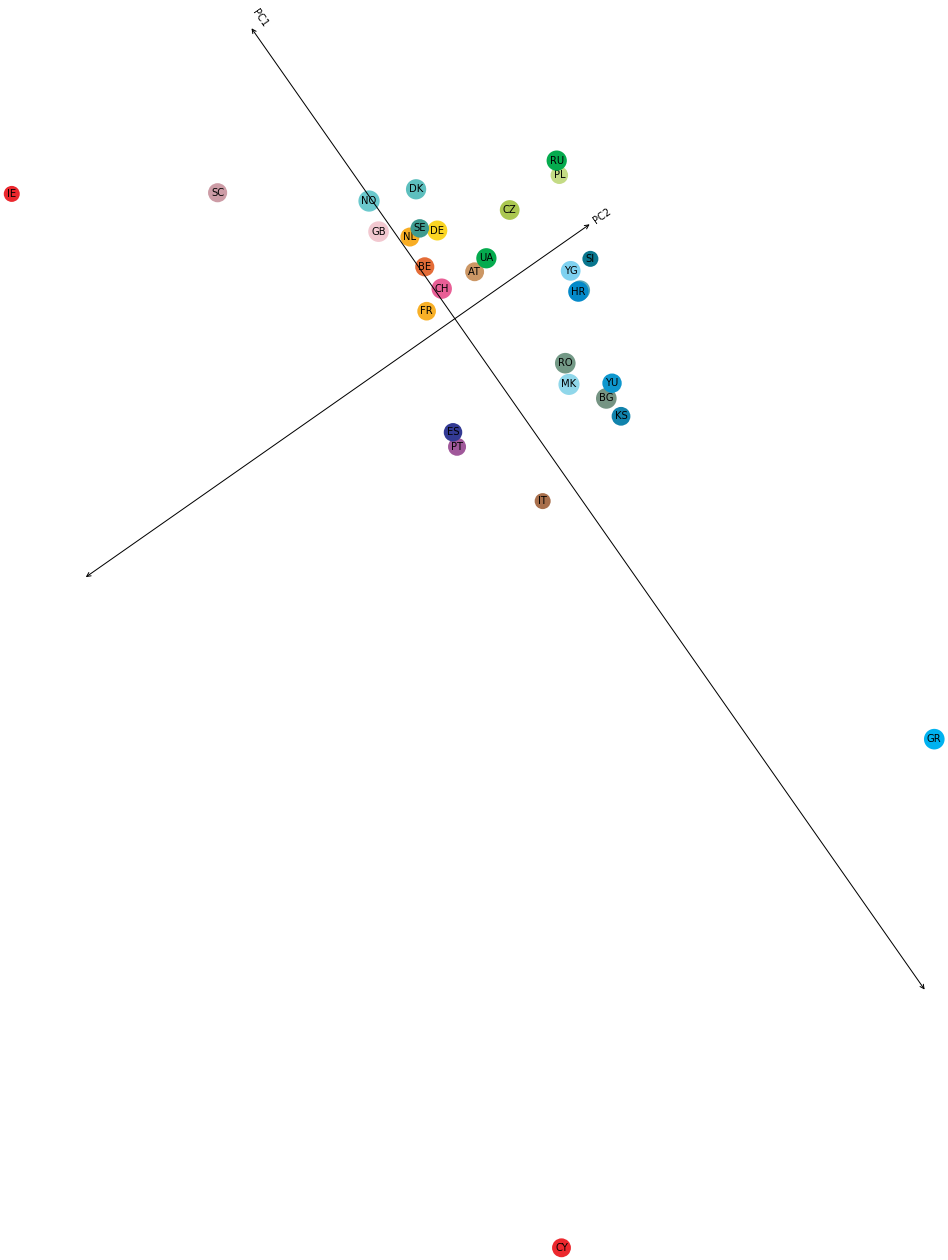

In [351]:
# robust + language markers only
df_plot, df_plot_means = get_plotting_data(res_lang_and_gen_20_1, df_labels_language)
print(res_lang_and_gen_20_1['PC_projection'].shape)
df_plot_means = adjust_plot_means_marker(df_plot_means, [ 
                                            ('YG',[-0.01,0]),
                                            ('YU',[-0.00,-0.005]),
                                            ('UA',[-0.00,-0.005]),
                                                    ])
f, axs = do_plot(df_plot, df_plot_means, plot_all=False, figsize=(20,20), theta=55)
f.savefig("./results/imgs/pca_norm_and_lang-20-means.svg")

(798, 10)


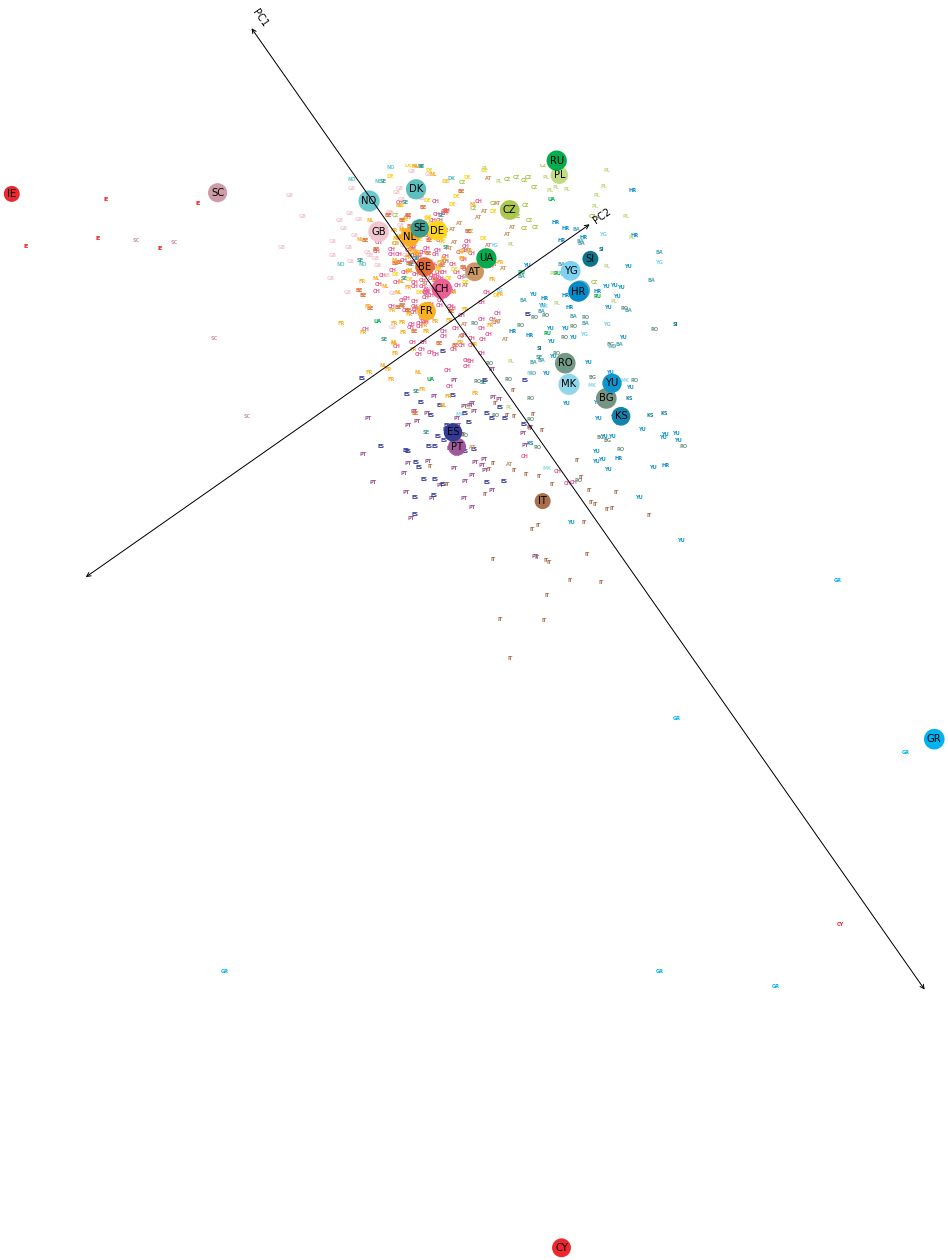

In [352]:
# robust + language markers only
df_plot, df_plot_means = get_plotting_data(res_lang_and_gen_20_1, df_labels_language)
print(res_lang_and_gen_20_1['PC_projection'].shape)
df_plot_means = adjust_plot_means_marker(df_plot_means, [ 
                                            ('YG',[-0.01,0]),
                                            ('YU',[-0.00,-0.005]),
                                            ('UA',[-0.00,-0.005]),
                                                    ])
f, axs = do_plot(df_plot, df_plot_means, plot_all=True, figsize=(20,20), theta=55)
f.savefig("./results/imgs/pca_norm_and_lang-20-means_and_samples.svg")